# 1. Data Preparation

In [8]:
import pandas as pd 
import re
import ast
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve,ConfusionMatrixDisplay,RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stat

Prepare the necessary files
1. stimulus : Description of the videos used to stimulate the subjects' emotion
2. gsr_data : Raw data obtained from the experiment
3. gsr_summary : Processed dataframe by utilizing statistical summary of each record
4. gsr_proc : Processed dataframe by utilizing time-series data of each record

## 1.1 Stimulus Information
This data set contains some minor informations of the videos used in the experiment.

In [2]:

stimulus["Target Emotion"]=stimulus["Target Emotion"].str.title()
stimulus.info()
stimulus.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Session ID            21 non-null     int64 
 1   Video ID              21 non-null     int64 
 2   Target Emotion        21 non-null     object
 3   Title of Video Clip   21 non-null     object
 4   Time Duration (secs)  21 non-null     int64 
 5   Active Link of Video  21 non-null     object
dtypes: int64(3), object(3)
memory usage: 1.1+ KB


,Session ID,Video ID,Target Emotion,Title of Video Clip,Time Duration (secs),Active Link of Video
0,1,1,Happy,Best Babies Laughing Video Compilation,39,https://drive.google.com/file/d/1ZWD1zyWkHcBI0...
1,1,2,Sad,Barely There,39,https://drive.google.com/file/d/13ysQgSsBwy3d8...
2,1,3,Neutral,Denali National Park Alaska,39,https://drive.google.com/file/d/1En_ARj18JlBLP...
3,1,4,Surprise,World's Highest Commercially Rafted Waterfall,39,https://drive.google.com/file/d/1kCIHXEklgpWds...
4,1,5,Disgust,Disgusting video compilation,39,https://drive.google.com/file/d/1mclmT0EAA-oZ6...


## 1.2 GSR Data
The raw GSR data will be joined to the experiment's result

In [3]:
# For first run only
gsr_data=pd.read_excel("/kaggle/input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Multimodal_Use.xlsx")
gsr_data["filename"]="GSRdata_s"+gsr_data["Session ID"].astype(str)+"p"+gsr_data["Participant Id"].astype(str)+"v"+gsr_data["Video ID"].astype(str)+".dat"
PATH_2="/kaggle/input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Raw Data/Multimodal/GSR/"
gsr_data["filename"]=gsr_data["filename"].str.replace('GSRdata_s2p9v3.dat','GSRdata_S2p9v3.dat',regex=False)
gsr_data["GSR_list"]=gsr_data["filename"].apply(lambda x: list(pd.read_table(PATH_2+x).iloc[:,0]))
gsr_data=gsr_data.merge(stimulus.iloc[:,0:3],on=["Session ID","Video ID"])
gsr_data.to_csv("gsr_data.csv",index=False)

In [4]:
gsr_data=pd.read_csv("/kaggle/working/gsr_data.csv")
gsr_data.info()
gsr_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Participant Id     252 non-null    int64 
 1   Session ID         252 non-null    int64 
 2   Video ID           252 non-null    int64 
 3   Name               252 non-null    object
 4   Age                252 non-null    int64 
 5   Gender             252 non-null    object
 6   Valence level      252 non-null    int64 
 7   Arousal level      252 non-null    int64 
 8   Dominance level    252 non-null    int64 
 9   Happy              252 non-null    object
 10  Sad                252 non-null    object
 11  Fear               252 non-null    object
 12  Anger              252 non-null    object
 13  Neutral            252 non-null    object
 14  Disgust            252 non-null    object
 15  Surprised          252 non-null    object
 16  Familiarity Score  113 non-null    object
 1

,Participant Id,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,Happy,...,Disgust,Surprised,Familiarity Score,Emotion,V_Label,A_Label,Four_Labels,filename,GSR_list,Target Emotion
0,1,1,1,M_M,13,Female,8,0,0,High,...,VeryLow,VeryLow,Never watched,Happy,HV,LA,HVLA,GSRdata_s1p1v1.dat,"[246.41, 246.59, 246.52, 246.58, 246.87, 247.0...",Happy
1,2,1,1,F_N,14,Male,5,2,0,VeryLow,...,VeryLow,VeryLow,Never watched,Mixed,LV,LA,LVLA,GSRdata_s1p2v1.dat,"[246.41, 246.59, 246.52, 246.58, 246.87, 247.0...",Happy
2,3,1,1,A_R,14,Male,7,2,0,High,...,VeryLow,VeryLow,Never watched,Happy,HV,LA,HVLA,GSRdata_s1p3v1.dat,"[246.41, 246.59, 246.52, 246.58, 246.87, 247.0...",Happy
3,4,1,1,At_R,12,Male,7,2,0,Moderate,...,VeryLow,VeryLow,Never watched,Mixed,HV,LA,HVLA,GSRdata_s1p4v1.dat,"[246.41, 246.59, 246.52, 246.58, 246.87, 247.0...",Happy
4,5,1,1,S_N,13,Male,6,0,9,High,...,VeryLow,Low,Never watched,Happy,HV,LA,HVLA,GSRdata_s1p5v1.dat,"[310.62, 310.69, 310.63, 310.55, 310.48, 310.4...",Happy


## 1.3 Feature Extraction GSR Data
We will be utilizing two different feature extraction method as follows:
1. Take the statistical summary (min, max, mean, variance, skewness, and kurtosis) for each GSR record, similar to the original code; and
2. Take the lists containing the GSR record for each row and break the list down into individual columns. Each of the individual column represents a time-series record index.

### 1.3.1 Feature extraction with statistical summary

In [5]:
# For first run only
gsr_summary=gsr_data[["Emotion","GSR_list"]].copy()
gsr_summary["GSR_list"]=gsr_summary["GSR_list"].apply(lambda x: ast.literal_eval(x))
gsr_summary["min"]=gsr_summary["GSR_list"].apply(lambda x: np.min(x))
gsr_summary["max"]=gsr_summary["GSR_list"].apply(lambda x: np.max(x))
gsr_summary["mean"]=gsr_summary["GSR_list"].apply(lambda x: np.mean(x))
gsr_summary["variance"]=gsr_summary["GSR_list"].apply(lambda x: np.var(x))
gsr_summary["kurtosis"]=gsr_summary["GSR_list"].apply(lambda x: stat.kurtosis(x))
gsr_summary["skewness"]=gsr_summary["GSR_list"].apply(lambda x: stat.skew(x))
gsr_summary=gsr_summary.drop(columns=["GSR_list"])
gsr_summary.to_csv("gsr_summary.csv",index=False)

In [6]:
gsr_summary=pd.read_csv("/kaggle/working/gsr_summary.csv")
gsr_summary.info()
gsr_summary.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Emotion   252 non-null    object 
 1   min       252 non-null    float64
 2   max       252 non-null    float64
 3   mean      252 non-null    float64
 4   variance  252 non-null    float64
 5   kurtosis  252 non-null    float64
 6   skewness  252 non-null    float64
dtypes: float64(6), object(1)
memory usage: 13.9+ KB


,Emotion,min,max,mean,variance,kurtosis,skewness
0,Happy,230.72,270.98,255.140222,95.695503,-1.154363,0.013905
1,Mixed,230.72,270.98,255.140222,95.695503,-1.154363,0.013905
2,Happy,230.72,270.98,255.140222,95.695503,-1.154363,0.013905
3,Mixed,230.72,270.98,255.140222,95.695503,-1.154363,0.013905
4,Happy,303.63,401.29,349.688034,920.290758,-1.297048,0.136309


### 1.3.2 Feature extraction with time-series

In [7]:
# For first run only
gsr_proc=gsr_data[["Emotion","GSR_list"]].copy()
gsr_proc["GSR_list"]=gsr_proc["GSR_list"].apply(lambda x: ast.literal_eval(x))
gsr_proc=pd.concat([gsr_proc,pd.DataFrame(gsr_proc['GSR_list'].tolist())],axis=1).drop(columns=["GSR_list"])
for i in range(gsr_proc.shape[1]-1):
    gsr_proc[i]=pd.to_numeric(gsr_proc[i])
gsr_proc.to_csv("gsr_proc.csv",index=False)

In [3]:
gsr_proc=pd.read_csv("gsr_proc.csv")
gsr_proc.info()
gsr_proc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Columns: 5000 entries, Emotion to 4998
dtypes: float64(4999), object(1)
memory usage: 9.6+ MB


,Emotion,0,1,2,3,4,5,6,7,8,...,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998
0,Happy,246.41,246.59,246.52,246.58,246.87,247.04,247.06,247.13,247.33,...,265.76,265.67,265.65,265.77,265.76,265.67,265.65,265.67,265.65,265.67
1,Mixed,246.41,246.59,246.52,246.58,246.87,247.04,247.06,247.13,247.33,...,265.76,265.67,265.65,265.77,265.76,265.67,265.65,265.67,265.65,265.67
2,Happy,246.41,246.59,246.52,246.58,246.87,247.04,247.06,247.13,247.33,...,265.76,265.67,265.65,265.77,265.76,265.67,265.65,265.67,265.65,265.67
3,Mixed,246.41,246.59,246.52,246.58,246.87,247.04,247.06,247.13,247.33,...,265.76,265.67,265.65,265.77,265.76,265.67,265.65,265.67,265.65,265.67
4,Happy,310.62,310.69,310.63,310.55,310.48,310.41,310.34,310.26,310.19,...,399.79,399.60,399.75,399.86,399.53,399.60,399.53,399.60,399.31,399.13


# 2 Exploratory Data Analysis

## 2.1 Experiment result

In [4]:
emos=['Happy', 'Mixed', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Neutral','Anger']

cm=confusion_matrix(gsr_data["Target Emotion"],gsr_data["Emotion"],labels=emos)
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=emos).plot(cmap="YlGnBu")
plt.ylabel("Intended Video Emotion",fontsize=14)
plt.xlabel("Experiment Result",fontsize=14)
plt.show()

NameError: name 'gsr_data' is not defined

Some of the videos evoked unintended emotion among the participants, namely videos that was used to stimulate sad, surprise, and neutral. This may be due to many unaccounted factors, such as the subject's interest, taste, or familiarity with the stimulant.

## 2.2 Plotting GSR for each emotion

<Figure size 640x480 with 0 Axes>

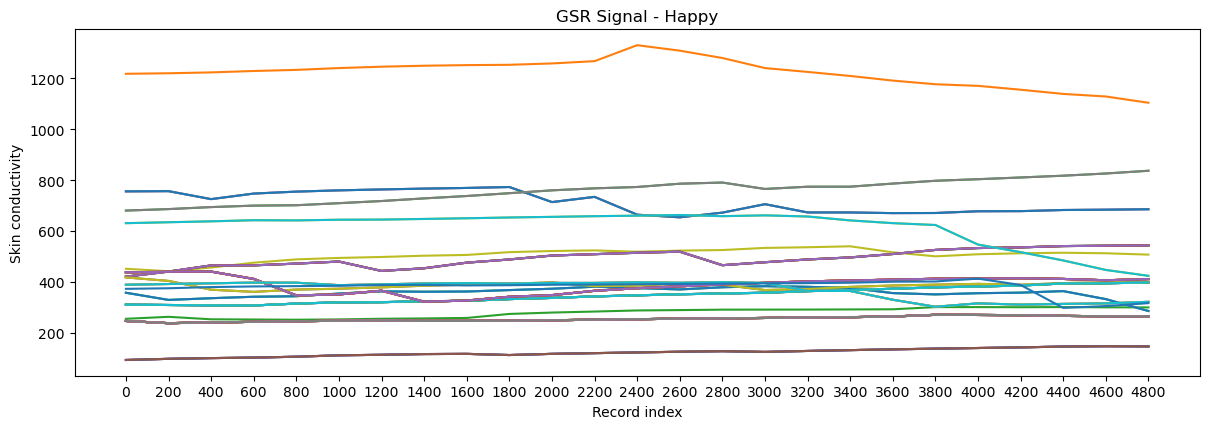

<Figure size 640x480 with 0 Axes>

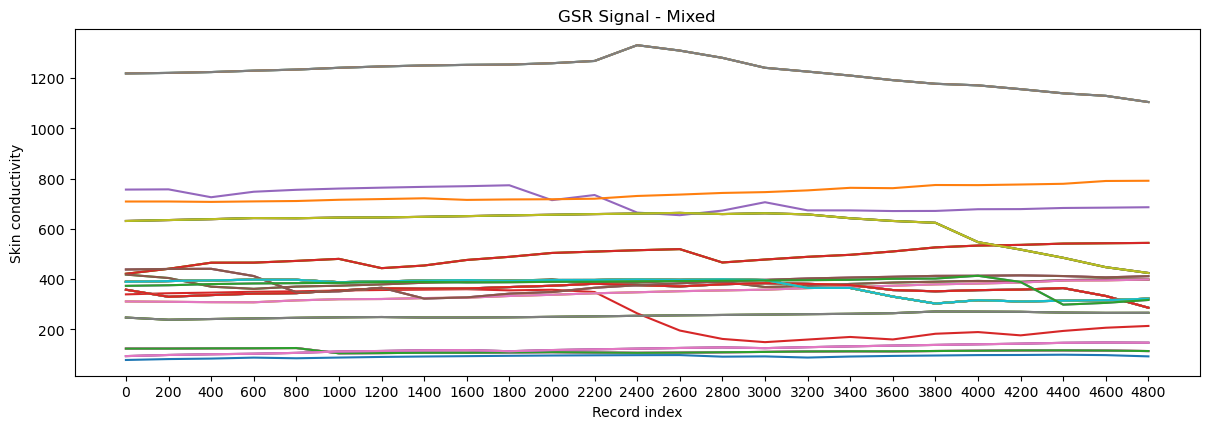

<Figure size 640x480 with 0 Axes>

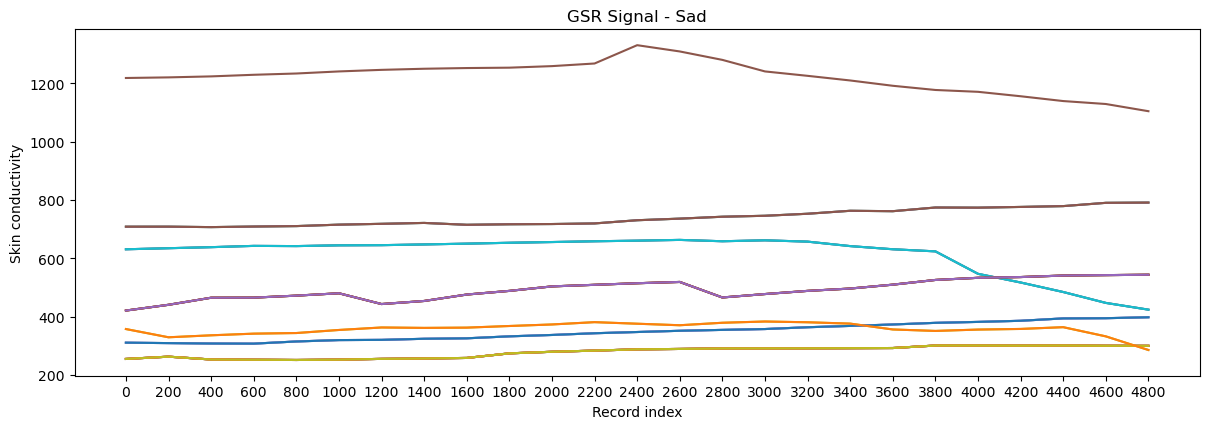

<Figure size 640x480 with 0 Axes>

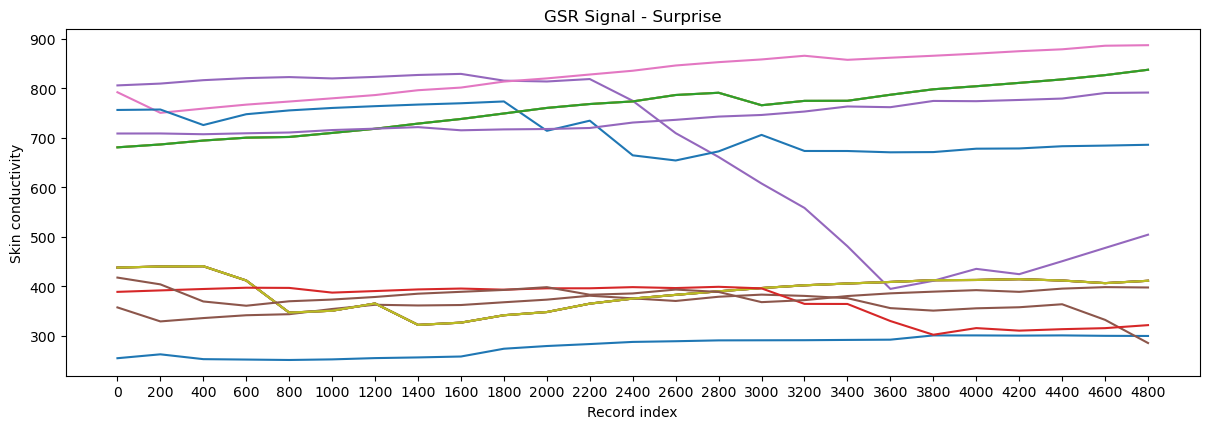

<Figure size 640x480 with 0 Axes>

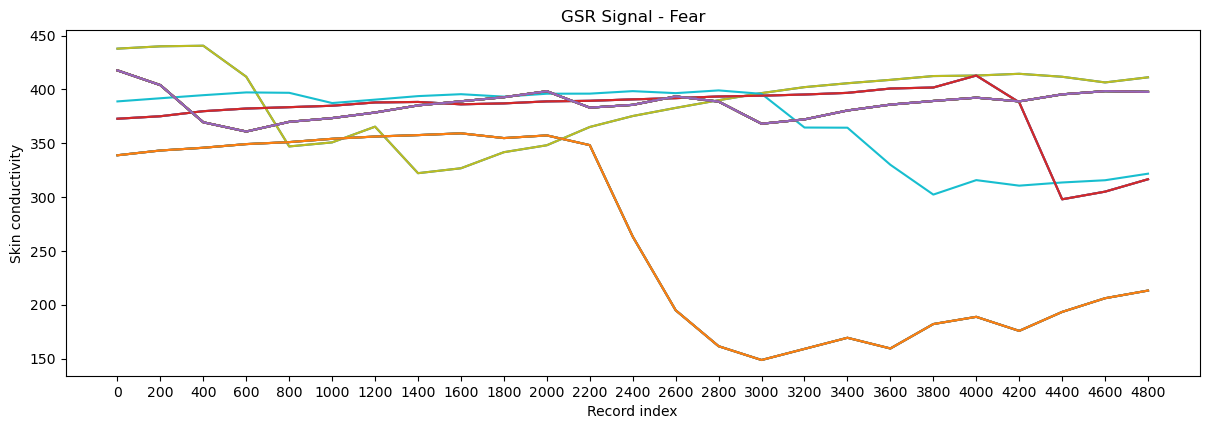

<Figure size 640x480 with 0 Axes>

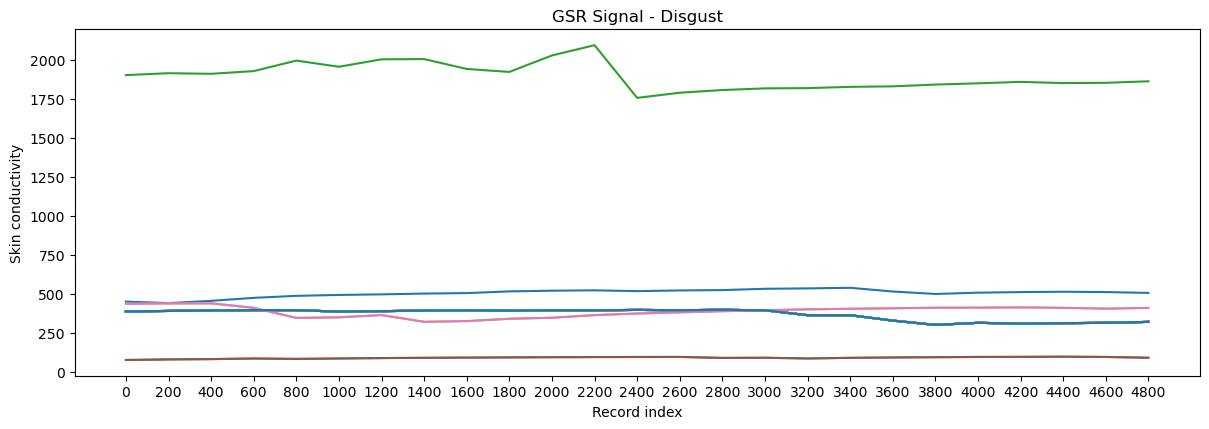

<Figure size 640x480 with 0 Axes>

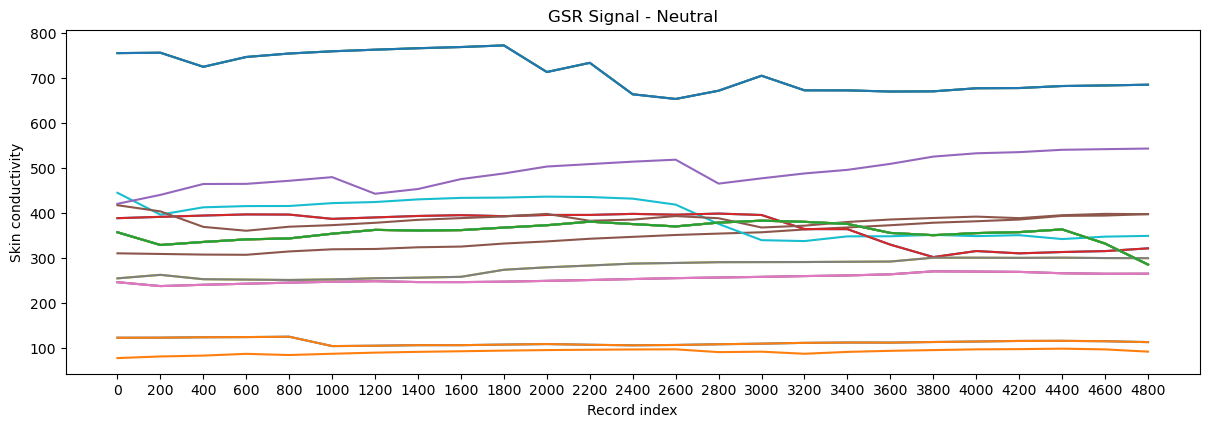

<Figure size 640x480 with 0 Axes>

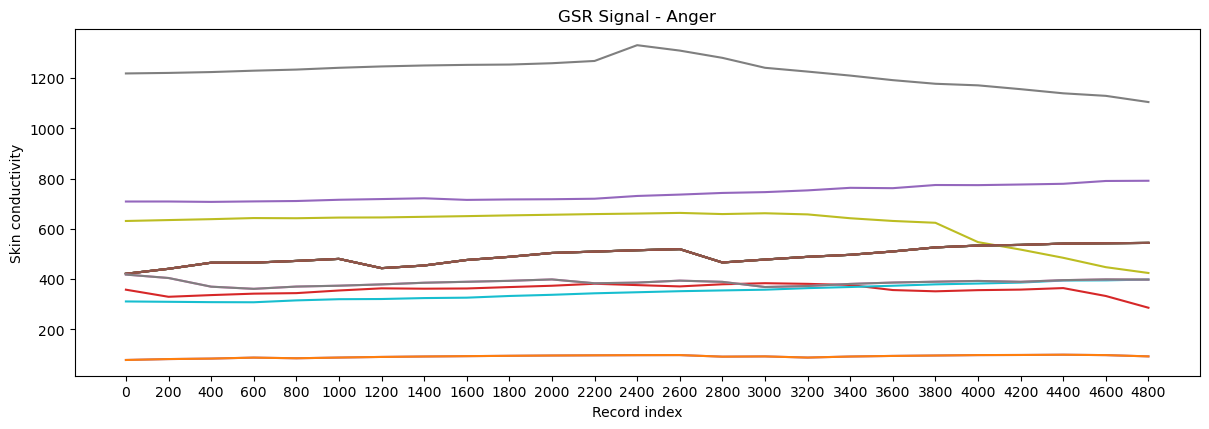

In [10]:
def plot_signals(data_arr, title = ''):
    plt.clf()
    plt.figure(figsize=(12, 4))
    
    for index, row in data_arr.iterrows():
        y = row
        plt.plot(y)
    
    plt.tight_layout()
    plt.title(title)
    plt.ylabel("Skin conductivity")
    plt.xlabel("Record index")
    plt.show()

for i in emos:
    plot_signals(gsr_proc[gsr_proc["Emotion"]==i].iloc[:,1:4998:200], "GSR Signal - "+i)

Some of the experiment subject's conductivity resulted in a very high value. Might treat it as an outlier and remove it later on

# 3. Model Creation
We will be using a 70:30 proportion for the testing and training split instead of the 80:20.

In [5]:
def model_eval(model,proc_data,label_name):
    train_data,test_data=train_test_split(proc_data,test_size=.3,random_state=3)
    model.fit(train_data.drop(columns=[label_name]),train_data[label_name])
    y_pred=model.predict(test_data.drop([label_name],axis=1))
    print(classification_report(test_data[label_name],y_pred))
    
    emos=['Happy', 'Mixed', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Neutral','Anger']
    cm=confusion_matrix(test_data[label_name],y_pred,labels=emos)
    ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=emos).plot(cmap="YlGnBu")
    plt.show()

## 3.1 Base Model

We will be trying a similar model without changing any of the hyperparameter.

### 3.1.1 Base Model with statistical Summary

In [6]:
model_eval(RandomForestClassifier(),gsr_summary,"Emotion")

NameError: name 'gsr_summary' is not defined

Slight .1 increase in accuracy and weighted average f1-score compared to Daniel's model, but still an overall bad one.

### 3.1.2 Base Model with time-series data

              precision    recall  f1-score   support

       Anger       0.50      0.67      0.57         3
     Disgust       0.44      0.78      0.56         9
        Fear       0.71      1.00      0.83         5
       Happy       0.60      0.62      0.61        24
       Mixed       0.50      0.14      0.21        22
     Neutral       0.00      0.00      0.00         5
         Sad       0.43      0.50      0.46         6
    Surprise       0.00      0.00      0.00         2

    accuracy                           0.46        76
   macro avg       0.40      0.46      0.41        76
weighted avg       0.49      0.46      0.44        76



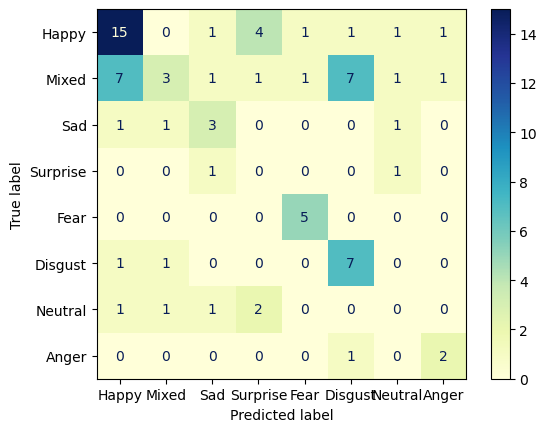

In [7]:
model_eval(RandomForestClassifier(),gsr_proc,"Emotion")

More or less similar to the one using statistical summary.

## 3.2 Normalizing data
We will try normalizing the data by dividing each values with the maximum of its column.

### 3.2.1 Normalized statistical summary

In [14]:
list(gsr_summary.drop(columns=["Emotion"]).columns)

['min', 'max', 'mean', 'variance', 'kurtosis', 'skewness']

In [15]:
gsr_summary["min"]

0      230.72
1      230.72
2      230.72
3      230.72
4      303.63
        ...  
247    360.02
248    360.02
249    360.02
250    360.02
251    360.02
Name: min, Length: 252, dtype: float64

In [16]:
norm_summary=gsr_summary.copy()
for i in norm_summary.drop(columns=["Emotion"]).columns:
    norm_summary[i]=norm_summary[i].apply(lambda x: x/norm_summary[i].max())

              precision    recall  f1-score   support

       Anger       0.50      0.67      0.57         3
     Disgust       0.43      0.67      0.52         9
        Fear       0.71      1.00      0.83         5
       Happy       0.57      0.71      0.63        24
       Mixed       0.38      0.14      0.20        22
     Neutral       0.00      0.00      0.00         5
         Sad       0.43      0.50      0.46         6
    Surprise       0.00      0.00      0.00         2

    accuracy                           0.47        76
   macro avg       0.38      0.46      0.40        76
weighted avg       0.44      0.47      0.43        76



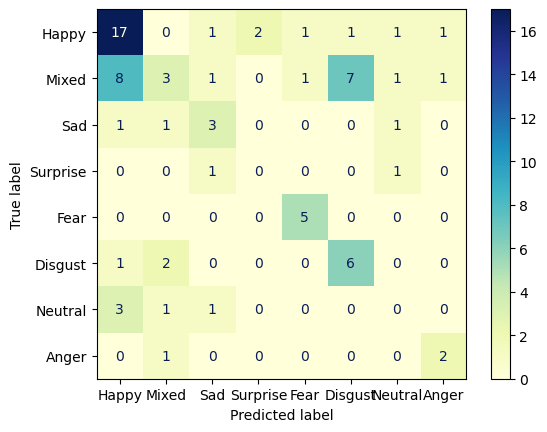

In [17]:
model_eval(RandomForestClassifier(),norm_summary,"Emotion")

Results in an even worse model.

### 3.2.2 Normalized time-series

In [18]:
norm_gsr=gsr_proc.copy()
for i in range(norm_gsr.shape[1]-1):
    norm_gsr[str(i)]=norm_gsr[str(i)].apply(lambda x: x/norm_gsr[str(i)].max())

              precision    recall  f1-score   support

       Anger       0.50      0.67      0.57         3
     Disgust       0.44      0.78      0.56         9
        Fear       0.60      0.60      0.60         5
       Happy       0.60      0.62      0.61        24
       Mixed       0.38      0.14      0.20        22
     Neutral       0.00      0.00      0.00         5
         Sad       0.43      0.50      0.46         6
    Surprise       0.00      0.00      0.00         2

    accuracy                           0.43        76
   macro avg       0.37      0.41      0.38        76
weighted avg       0.44      0.43      0.42        76



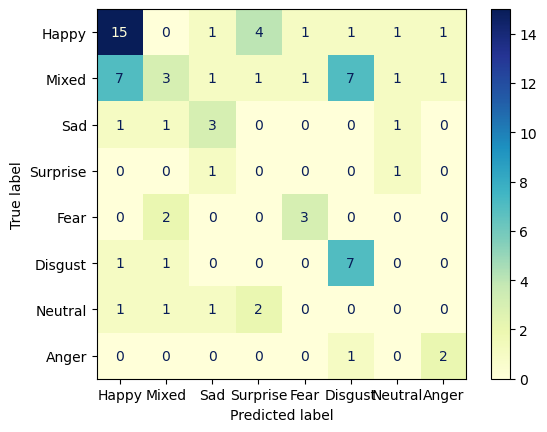

In [19]:
model_eval(RandomForestClassifier(),norm_gsr,"Emotion")

# Conclusion and Recommendation
Model is not viable enough to be used for recognizing emotion, this may be due several reasons:
1. The data set contains outlier that need to be cleaned before using it to train the model. Try cleaning the outliers for each record index by using various methods, e.g. removing or imputing data based on interquartile range.
2. One physiological modal may not be enough to create a robust model. Considering that the dataset offers both ECG and GSR data, utilizing both may result in a better model.
3. The use of time-series data seems to be more effective albeit only slightly, but it's very costly in terms of computation time.